In [ ]:
import collections.abc
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping

import matplotlib as mpl
import matplotlib.animation
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib ipympl
import h5py 

plt.rcParams['figure.figsize'] = [10, 4]
plt.rcParams['font.size'] = 8
mpl.rc('image', cmap='gray')
import trackpy as tp
tp.quiet()

import joblib 

import numpy as np
import pandas as pd
import csv, json
import pims
from PIL import Image, ImageDraw
import cv2

from scipy.optimize import dual_annealing, linear_sum_assignment
from scipy.spatial import distance_matrix
from tqdm import tqdm
import random

import skimage
from csbdeep.utils import normalize
from stardist.models import StarDist2D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize
from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
np.random.seed(6)
lbl_cmap = random_label_cmap()
# initialize model with versatile fluorescence pretrained weights
model = StarDist2D.from_pretrained('2D_versatile_fluo')
print(model)

source_path = './data/25r25b-1.mp4'
path = './25b_25r/'
data_preload_path = '/Volumes/ExtremeSSD/UNI/h5_data_thesis/data.h5'
correct_n = 50
# for 49 blue 1 red video --> 920, 960, 55, 55, 880, 880 
# for 25 blue 25 red video --> 480, 640, 100, 35, 530, 465

In [ ]:
@pims.pipeline
def preprocessing(image, w, h, x1, y1, x2, y2):
    """
    Preprocessing function for the data.

    Parameters
    ----------
    image : pims.Frame
        Frame of the video.
    x1 : int
        x coordinate of the top left corner of the ROI. (region of interest)
    y1 : int
        y coordinate of the top left corner of the ROI.
    x2 : int    
        x coordinate of the bottom right corner of the ROI.
    y2 : int    
        y coordinate of the bottom right corner of the ROI.

    Returns
    -------
    npImage : np.array
        Preprocessed image.
    """
    npImage = np.array(image)
    alpha = Image.new('L', (h, w), 0)
    draw = ImageDraw.Draw(alpha)
    draw.pieslice(((x1, y1), (x2, y2)), 0, 360, fill=255)
    npAlpha = np.array(alpha)
    npImage = cv2.cvtColor(npImage, cv2.COLOR_BGR2GRAY)*npAlpha
    ind = np.where(npImage == 0)
    npImage[ind] = npImage[200, 200]
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    # sharpen image https://en.wikipedia.org/wiki/Kernel_(image_processing)
    image_sharp = cv2.filter2D(src=npImage, ddepth=-1, kernel=kernel)
    return npImage

In [ ]:
ref = pims.open(source_path)
print(ref)
data = preprocessing(ref, 480, 640, 100, 35, 530, 465) 
nFrames = 1000
framesList = np.arange(0, nFrames, 1)

In [ ]:
def get_frame(frame):
    with h5py.File(data_preload_path, 'r') as f:
        # Access the dataset within the HDF5 file
        dataset = f['dataset_name']
        frameImg = dataset[frame]
    return frameImg

In [ ]:
if 0:
    preprocessed_data = np.zeros((nFrames, data[0].shape[0], data[0].shape[1]), dtype=data[0].dtype)
    for i in tqdm(range(nFrames)):
        preprocessed_data[i] = data[i]
else:
    # Open the HDF5 file in read mode
    with h5py.File(data_preload_path, 'r') as f:
        # Access the dataset within the HDF5 file
        dataset = f['dataset_name']
        preprocessed_data = dataset[framesList[0]:framesList[-1]+1]

100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


[51, 52, 52, 51, 53, 52, 54, 53, 51, 52]


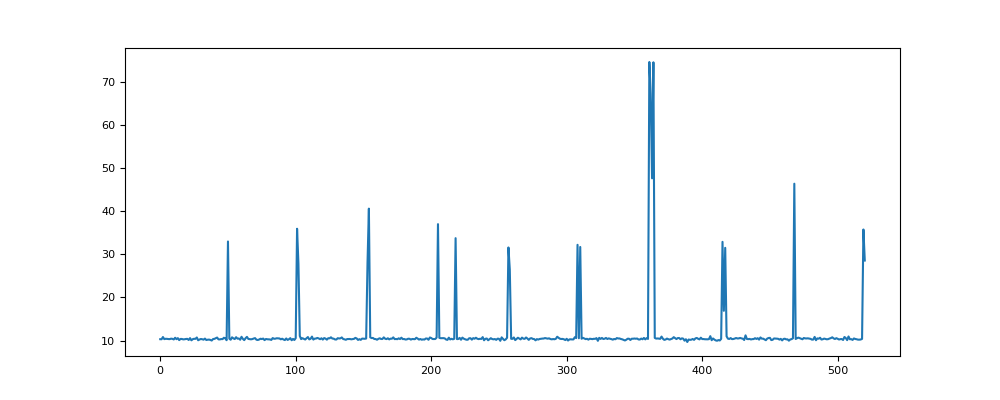

In [7]:
## TEST
if 1:
    droplets_found = []
    area = []
    frames_sample = np.random.choice(np.arange(0, preprocessed_data.shape[0], 1), 10, replace=False)

    for frame in tqdm(frames_sample):
        img = preprocessed_data[frame]
        labels_test, dict_test = model.predict_instances(normalize(img), predict_kwargs = {'verbose':False}) 
        droplets_found.append(dict_test['coord'].shape[0])
        test = skimage.measure.regionprops_table(labels_test, properties=('centroid', 'area'))
        area += list(test['area'])
        """
        plt.figure(figsize = (10, 5))
        coord, points, prob = dict_test['coord'], dict_test['points'], dict_test['prob']
        ax = plt.subplot(121)
        ax.imshow(img, cmap='gray'); 
        ax.set(title = 'Preprocessed Image', xlabel='x', ylabel='y')
        ax1 = plt.subplot(122, sharex=ax, sharey=ax)
        ax1.imshow(img, cmap='gray'); 
        _draw_polygons(coord, points, prob, show_dist=True)
        ax1.set(title = f"Stardist result - {dict_test['coord'].shape[0]} droplets found", xlabel='x', ylabel='y')
        plt.tight_layout()
        plt.savefig(path + f'test_samples/test{frame}.pdf', format='pdf')
        plt.close()
        """
print(droplets_found)
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(np.sqrt(area)/np.sqrt(np.pi))
plt.show()

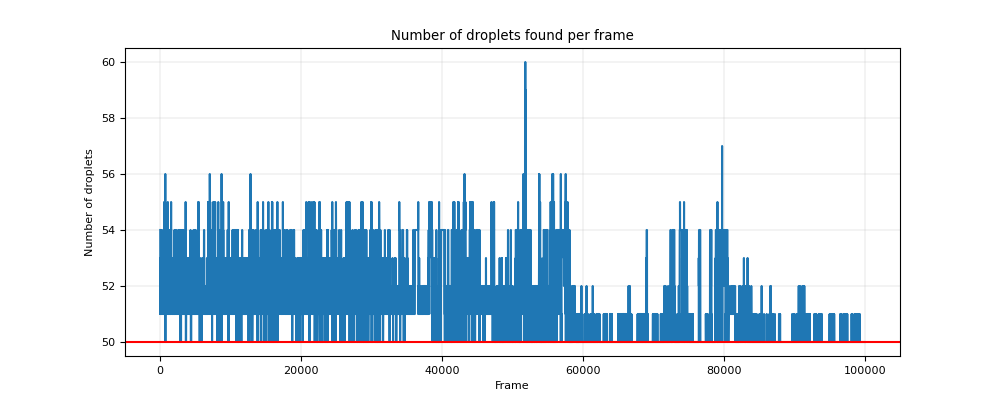

In [177]:
df = pd.read_parquet(path + 'df.parquet')
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(df.frame.unique(), df.groupby('frame').count().x.values)
ax.axhline(correct_n, color='r')
ax.set(title = 'Number of droplets found per frame', xlabel='Frame', ylabel='Number of droplets')
ax.grid(linewidth=0.2)
plt.show()

In [ ]:
# filter found features
df = df.loc[df.r.between(8.3, 13)]
df = df.groupby('frame').apply(lambda x: x.nlargest(correct_n, 'prob'))
df = df.reset_index(drop=True)
print("frames:", len(df.frame.unique()))
fig, ax = plt.subplots(2, 2, figsize=(10, 4))
ax[0, 0].plot(df.frame.unique(), df.groupby('frame').count().x.values)
ax[0, 1].plot(df.r, '.')
ax[1, 0].hist(df.area, bins=100, density=True)
ax[1, 1].scatter(df.r, df.prob, s=0.1)
plt.show()

In [ ]:
err_frames = np.where(df.groupby('frame').count().x != correct_n)[0] + df.frame.min()
print(len(err_frames), err_frames)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(get_frame(err_frames[-1]), cmap='gray')
for i in range(len(df.loc[df.frame == err_frames[-1]])):
    ax.add_artist(plt.Circle((df.loc[df.frame == err_frames[-1]].x.values[i], df.loc[df.frame == err_frames[-1]].y.values[i]), df.loc[df.frame == err_frames[-1]].r.values[i], color='r', fill=False))
plt.show()

In [ ]:
mmmeh_frames = df.loc[df.r < 8.5].frame.unique()
print(mmmeh_frames)
frame = mmmeh_frames[1]
df_plot = df.loc[df.frame == frame]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(get_frame(frame), cmap='gray')
for i in range(len(df_plot)):
    ax.add_artist(plt.Circle((df_plot.x.values[i], df_plot.y.values[i]), df_plot.r.values[i], color='r', fill=False))
ax.set(title='Labeled elements', xlabel='x', ylabel='y', xlim=(0, 600), ylim=(600, 0))
plt.show()

In [ ]:
# Function to interpolate missing values for each group
def interpolate_trajectory(group):
    all_frames = pd.DataFrame({"frame": range(group["frame"].min(), group["frame"].max() + 1)})
    merged = pd.merge(all_frames, group, on="frame", how="left")
    merged.sort_values(by="frame", inplace=True)
    # Interpolate missing values
    merged["x"] = merged["x"].interpolate(method = "polynomial", order = 3)
    merged["y"] = merged["y"].interpolate(method = "polynomial", order = 3)
    merged["r"] = merged["r"].interpolate(method = "polynomial", order = 3)
    merged["area"] = merged["area"].interpolate(method = "polynomial", order = 3)
    merged["prob"] = merged["prob"].interpolate(method = "polynomial", order = 3)
    merged["frame"] = merged["frame"].interpolate(method = "polynomial", order = 3)
    merged["particle"].ffill(inplace=True)
    merged["color"].ffill(inplace=True)
    return merged

In [163]:
#############################################################################################################
#                                         LINK FEATURES WITH TRACKPY                                        #
#############################################################################################################
if 0:
    t = tp.link_df(df, 100, memory = 5, link_strategy = 'hybrid', neighbor_strategy = 'KDTree', adaptive_stop = 1)
    #print(t)
    t = t.sort_values(['frame', 'particle'])
    t_filtered = tp.filter_stubs(t, 25)

    # CREATE COLOR COLUMN AND SAVE DF
    n = max(t_filtered.particle)
    print(f"N of droplets: { n + 1}")
    random.seed(5)
    colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(n)]
    for i in range(max(t_filtered.particle)+1-n):
        colors.append("#00FFFF")
    c = []
    for p in t.particle:
        c.append(colors[p])
    t["color"] = c
    t.to_parquet(path + 'df_linked_raw.parquet', index=False)

    missing_droplets = {}
    confront_array = np.arange(correct_n)
    for err_frame in err_frames:
        frame_df = t.loc[t.frame == err_frame]
        missing_droplets[err_frame] = np.setdiff1d(confront_array, frame_df.particle.values)[0]
    print(missing_droplets)
    missing_droplets_df = pd.DataFrame.from_dict(missing_droplets, orient='index', columns=['particle'])
    missing_droplets_df['frame'] = missing_droplets_df.index
    missing_droplets_df.reset_index(drop = True, inplace = True)
    missing_droplets_df.to_parquet(path + 'missing_droplets.parquet', index=False)

    # fill missing positions, radii, areas and probabilities with interpolation (polynomial order 3)
    grouped = trajectory.groupby("particle")
    # Apply interpolation to fill missing points for each droplet
    rawTrajs = grouped.apply(interpolate_trajectory)
    # Reset the index of the filled dataframe
    rawTrajs.reset_index(drop=True, inplace=True)
    rawTrajs["particle"] = rawTrajs["particle"].astype(int)
    rawTrajs.to_parquet(path + 'df_linked.parquet', index=False)
else:
    t = pd.read_parquet(path + 'df_linked_raw.parquet')
    trajectory = pd.read_parquet(path + 'df_linked.parquet')
    missing_droplets = pd.read_parquet(path + 'missing_droplets.parquet')
    print(f"Number of error frames: {len(missing_droplets)}")

N of error frames: 16


In [175]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(t.groupby("frame").size(), color = "k", label = "n of droplets")
ax.axhline(correct_n, color = "r", linestyle = "--", label = "correct n")
ax.set(xlabel = "frame", ylabel = "n")
ax.set_title("Number of droplets per frame - pre interpolation")
ax.grid(linewidth = 0.2)
ax.legend()
plt.savefig(path + 'n_of_droplets_raw.png', bbox_inches='tight')
plt.close()

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(trajectory.groupby("frame").size(), color = "k", label = "n of droplets")
ax.axhline(correct_n, color = "r", linestyle = "--", label = "correct n")
ax.set(xlabel = "frame", ylabel = "n")
ax.set_title("Number of droplets per frame - after interpolation")
ax.grid(linewidth = 0.2)
ax.legend()
plt.savefig(path + 'n_of_droplets.png', bbox_inches='tight')
plt.close()

# example of interpolation
raw = t.loc[(t.frame.between(missing_droplets.frame.values[0]-5, missing_droplets.frame.values[0]+5)) & (t.particle == missing_droplets.particle.values[0])]
interpolated = trajectory.loc[(trajectory.frame.between(missing_droplets.frame.values[0]-5, missing_droplets.frame.values[0]+5)) & (trajectory.particle == missing_droplets.particle.values[0])]
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True, sharex=True)
ax.plot(raw.x, raw.y, '--bo')
ax1.plot(interpolated.x, interpolated.y, '--ro')
ax.set(title='Raw trajectory', xlabel = 'X [px]', ylabel = 'Y [px]')
ax1.set(title='Interpolated trajectory', xlabel = 'X [px]', ylabel = 'Y [px]')
plt.savefig(path + 'interpolation_example.png', bbox_inches='tight')
ax.grid(linewidth = 0.2)
ax1.grid(linewidth = 0.2)
plt.close()

In [ ]:
fig = plt.figure(figsize = (5, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(frame):
    df = trajectory.loc[(trajectory.frame == frame) , ["x", "y", "color", "r"]]
    for i in range(len(df)):
        graph[i].center = (df.x.values[i], df.y.values[i])
        graph[i].radius = df.r.values[i]
    graph2.set_data(preprocessed_data[frame-trajectory.frame.min()])
    title.set_text('Tracking raw - frame = {}'.format(frame))
    return graph

ax = fig.add_subplot(111)
title = ax.set_title('Tracking stardist + trackpy - frame = 0')
ax.set(xlabel = 'X [px]', ylabel = 'Y [px]')
df = trajectory.loc[(trajectory.frame == trajectory.frame.min()), ["x", "y", "color", "r"]]

graph = []
for i in range(len(df)):
    graph.append(ax.add_artist(plt.Circle((df.x.values[i], df.y.values[i]), df.r.values[i], color = df.color.values[i],\
                                           fill = False, linewidth=1)))
graph2 = ax.imshow(preprocessed_data[0])

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, range(trajectory.frame.min(), trajectory.frame.max(), 1), interval = 5, blit=False)
if 1: 
    writer = matplotlib.animation.FFMpegWriter(fps = 30, metadata = dict(artist='Matteo Scandola'), extra_args=['-vcodec', 'libx264'])
    ani.save(path + 'tracking.mp4', writer=writer, dpi = 300)
plt.close()